In [1]:
import sys
import logging

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from torch.utils.data import DataLoader

In [5]:
import torchvision
from torchvision import datasets
from torchvision.utils import make_grid

In [6]:
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)],
)

# Data Load

In [7]:
train_dataset = datasets.MNIST(
    root='data',
    train=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda x: torch.ceil(x)),
    ]),
    download=True,
)

In [8]:
test_dataset = datasets.MNIST(
    root='data',
    train=False,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda x: torch.ceil(x)),
    ]),
    download=False,
)

In [9]:
len(train_dataset), len(test_dataset)

(60000, 10000)

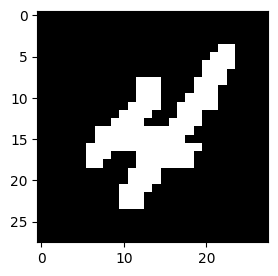

In [10]:
plt.figure(figsize=(3,3))
plt.imshow(train_dataset[9][0].detach().cpu().numpy()[0], cmap='gray')

In [11]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [12]:
for batch in train_loader:
    data, labels = batch
    print(data.shape)
    print(labels.shape)
    break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([64, 1, 28, 28])
torch.Size([64])


# Model

In [13]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert mask_type in ('A', 'B')
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

In [14]:
def test_masked_conv2d():
    layer = MaskedConv2d(mask_type='A', in_channels=2, out_channels=2, kernel_size=5)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.zeros((2, 2)))

    layer = MaskedConv2d('B', in_channels=2, out_channels=2, kernel_size=5)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.ones((2, 2)))

In [15]:
test_masked_conv2d()

In [16]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, n_filters):
        super().__init__(n_filters)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        out = super().forward(x)
        return out.permute(0, 3, 1, 2).contiguous()

In [17]:
class ConvBlock(nn.Module):
    def __init__(
        self,
        mask_type: str,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        padding: int,
    ):
        super(ConvBlock, self).__init__()

        self.layer = nn.Sequential(
            MaskedConv2d(
                mask_type=mask_type,
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                padding=padding,
            ),
            LayerNorm(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layer(x)

In [18]:
class PixelCNN(nn.Module):
    def __init__(
        self,
        input_shape: tuple,
        n_filters: int,
        n_layers: int,
        kernel_size: int,
    ):
        super(PixelCNN, self).__init__()
        self.input_shape = input_shape
        padding = kernel_size // 2

        layers = nn.ModuleList()
        layers.append(ConvBlock('A', 1, n_filters, kernel_size, padding))
        for _ in range(n_layers):
            layers.append(ConvBlock('B', n_filters, n_filters, kernel_size, padding))
        layers.append(MaskedConv2d(
            mask_type='B',
            in_channels=n_filters,
            out_channels=2,
            kernel_size=kernel_size,
            padding=padding,
        ))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        batch_size = x.shape[0]
        normalized = (x.float() - 0.5) / 0.5
        out = self.model(x)
        return out.view(batch_size, 2, 1, *self.input_shape)

In [19]:
def count_parameters(model: nn.Module):
    """Количество обучаемых параметров модели"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [20]:
model = PixelCNN(
    input_shape=(28, 28),
    n_filters=64,
    n_layers=5,
    kernel_size=5,
)

In [21]:
print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 517,954 trainable parameters


In [22]:
model(data).shape

torch.Size([64, 2, 1, 28, 28])

In [23]:
def sample(n, device='cpu'):
    # read carefully the sampling process
    model.eval()
    samples = torch.zeros(n, 1, *model.input_shape)
    with torch.no_grad():
        for r in tqdm(range(model.input_shape[0])):
            for c in range(model.input_shape[1]):
                logits = model(samples.to(device))[:, :, :, r, c]
                probs = F.softmax(logits, dim=1).squeeze(-1)
                samples[:, 0, r, c] = torch.multinomial(probs, num_samples=1).squeeze(-1)
    return samples.cpu().numpy()

In [24]:
sample(2).shape

100%|██████████| 28/28 [00:29<00:00,  1.06s/it]


(2, 1, 28, 28)

In [25]:
criterion = nn.CrossEntropyLoss()

In [26]:
criterion(model(data), data.long())

tensor(0.6479, grad_fn=<NllLoss2DBackward0>)

In [27]:
data.shape

torch.Size([64, 1, 28, 28])

# Train

In [28]:
def train(
    model: nn.Module,
    train_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str,
    clip: float = 3.0,
    train_history=None,
    valid_history=None,
):
    epoch_loss = 0
    history = []

    model.train()
    for i, batch in enumerate(tqdm(train_loader)):
        data = batch[0].to(device)
        labels = batch[1].to(device)

        output = model(data)

        loss = criterion(
            output,
            data.long(),
        )
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        history.append(loss.cpu().data.numpy())
        if ((i + 1) % 30 == 0) or (i == (len(train_loader) - 1)):
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

            clear_output(True)
            ax[0].plot(history, label="train loss")
            ax[0].set_xlabel("Batch")
            ax[0].set_title("Train loss")
            if train_history is not None:
                ax[1].plot(train_history, label="general train history")
                ax[1].set_xlabel("Epoch")
            if valid_history is not None:
                ax[1].plot(valid_history, label="general valid history")
            plt.legend()

            plt.show()
        i += 1

    return epoch_loss / len(train_loader), loss

In [29]:
def validate(
    model: nn.Module, valid_loader: DataLoader, criterion: nn.Module, device: str
):

    epoch_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            data = batch[0].to(device)
            labels = batch[1].to(device)

            output = model(data)
            loss = criterion(
                output,
                data.long(),
            )
            epoch_loss += loss.item()

    return epoch_loss / len(valid_loader)

In [30]:
def fit(
    model: nn.Module,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    criterion,
    optimizer,
    start_epoch: int,
    end_epoch: int,
    clip: float = 3.0,
):

    train_losses = []
    valid_losses = []


    for epoch in range(start_epoch, end_epoch):
        train_loss, last_batch_loss = train(
            model,
            train_loader,
            criterion,
            optimizer,
            device,
            clip,
            train_losses,
            valid_losses,
        )
        valid_loss = validate(model, valid_loader, criterion, device)
        logging.info(
            f"Epoch: {epoch}, Training Loss: {train_loss}, Valid Loss: {valid_loss}"
        )

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

    return train_losses, valid_losses

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [32]:
model.to(device)
print()

In [33]:
start_epoch = 0
end_epoch = 10
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

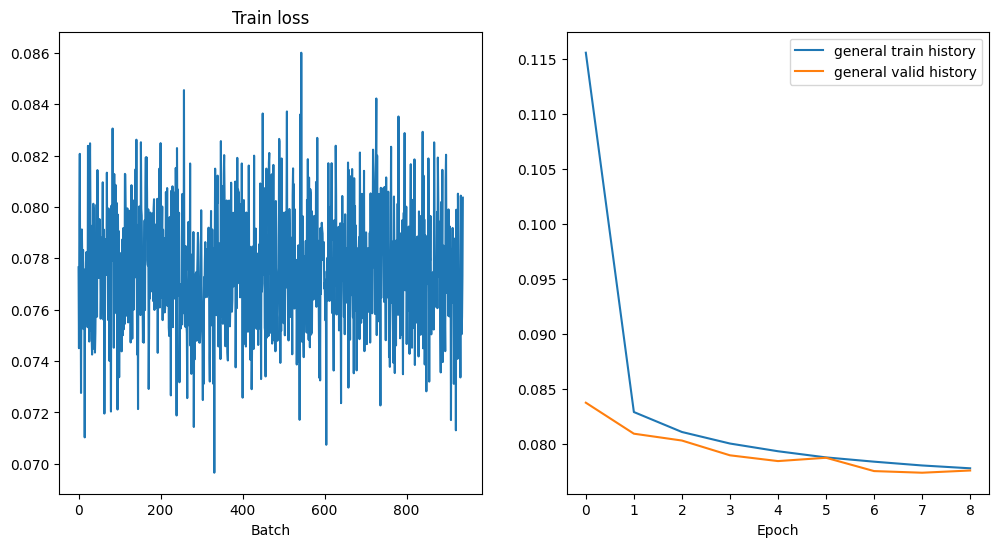

100%|██████████| 157/157 [00:02<00:00, 58.30it/s]


In [34]:
train_losses, valid_losses = fit(
    model=model,
    train_loader=train_loader,
    valid_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    start_epoch=start_epoch,
    end_epoch=end_epoch,
)

# Test

In [35]:
def show_samples(samples, title, figsize=None, nrow=None):
    if isinstance(samples, np.ndarray):
        samples = torch.FloatTensor(samples)
    if nrow is None:
        nrow = int(np.sqrt(len(samples)))
    grid_samples = make_grid(samples, nrow=nrow, pad_value=1, padding=1)

    grid_img = grid_samples.permute(1, 2, 0)
    if figsize is None:
        figsize = (6, 6)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(grid_img)
    plt.axis('off')
    plt.show()

In [36]:
samples = sample(25, device)

100%|██████████| 28/28 [00:05<00:00,  4.87it/s]


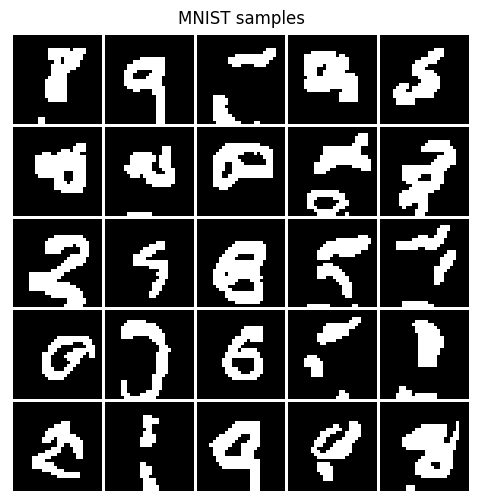

In [37]:
show_samples(samples, title='MNIST samples', nrow=5)

# Blind Spot

In [38]:
def plot_receptive_field(model, n_layers, size=28, device='cpu'):

    x_center = size // 2
    y_center = size // 2
    dummy_input = torch.zeros(
        (1, 1, size, size),
        requires_grad=True,
        device=device
    )

    output = model(dummy_input)
    output[0, :, 0, size // 2, size // 2].sum().backward()

    binary_map = (
        dummy_input
        .grad
        .view(size, size)
        .abs()
        .cpu()
        .detach()
        .numpy() > 1e-8
    ).astype(np.float64)

    # stack the maps to get RGB image
    binary_map = np.stack([binary_map, binary_map, binary_map], axis=-1)

    # center point will be red
    binary_map[x_center, y_center] = [1, 0, 0]

    plt.imshow(binary_map, vmin=0.0, vmax=1.0)
    plt.title(f"Binary receptive field for {n_layers} layers")
    plt.show()

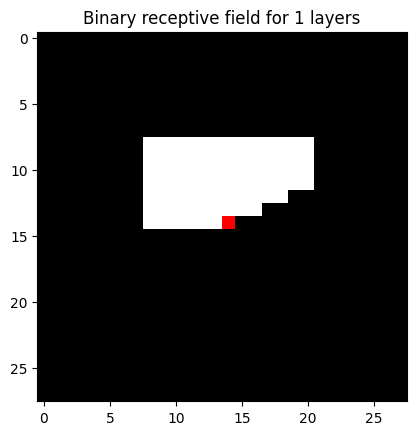

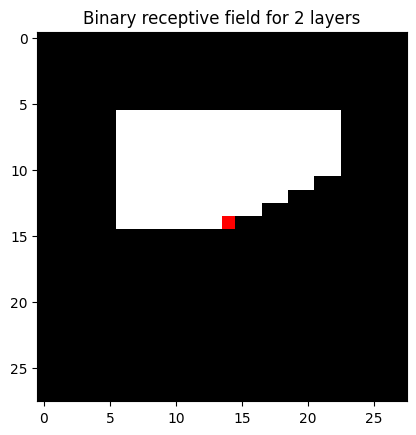

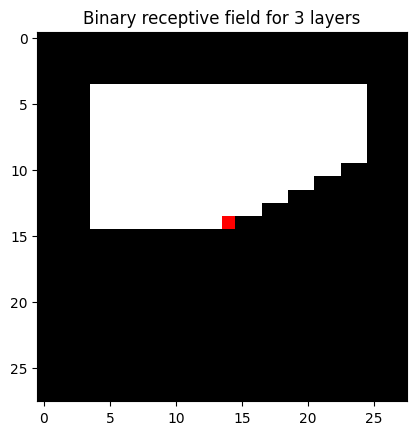

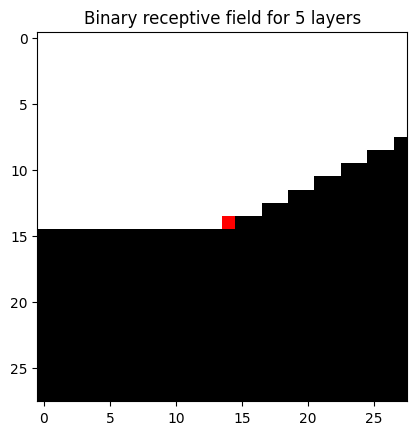

In [39]:
for n_layers in [1, 2, 3, 5]:
    model = PixelCNN(
        input_shape=(28, 28),
        n_filters=64,
        n_layers=n_layers,
        kernel_size=5,
    )
    plot_receptive_field(model, n_layers, 28)

PixelCNN имеет blind spot на правой стороне рецептивного поля из-за использования маски для исключения «будущих» пикселей при предсказании текущего пикселя. Маска обнуляет пиксели справа от прогнозируемого пикселя, что приводит к потере информации и созданию слепых пятен.